In [15]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [16]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta


# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text, desc

In [18]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo = False)

In [19]:
#just checking table types
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [20]:
#just checking column types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [21]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [22]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine) 
# reflect the tables


In [23]:
# View all of the classes that automap found/same as inspect 
Base.classes.keys()

['measurement', 'station']

In [24]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [25]:
# Create our session (link) from Python to the DB
session = Session(engine)



# Exploratory Precipitation Analysis

In [26]:
# Find the most recent date in the data set.

most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

#most_recent_date = session.query(measurement['date']).max()

print("Most recent date:", most_recent_date)

Most recent date: 2017-08-23


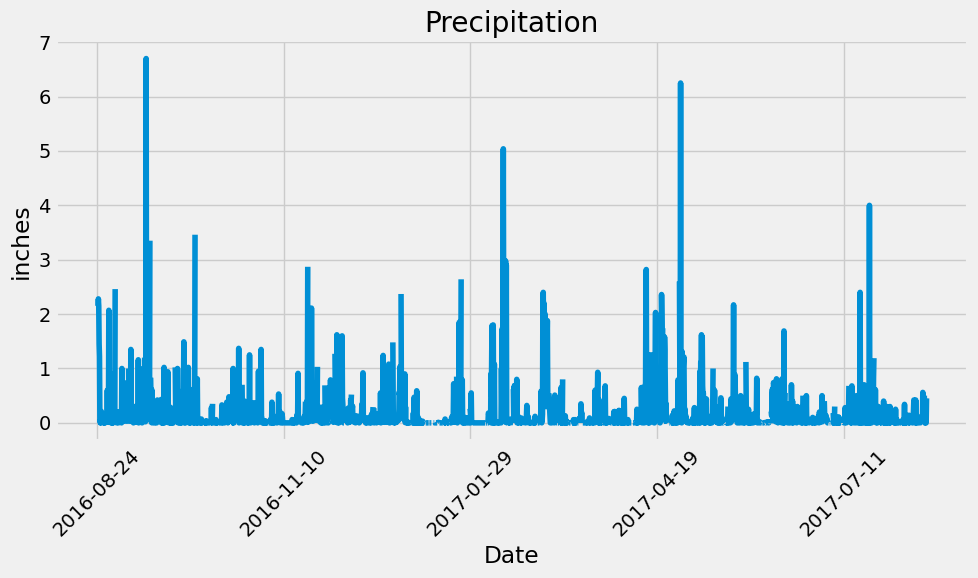

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set

#creating query object that selects 'date' column from 'Measurement' table
#order by descending order 'date'column/ .first gets the first result
# datetime.strptime() creates datetime object from string
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date

df_sorted = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
df_sorted.plot(x='Date', y='Precipitation', figsize=(10, 6), legend=False)
plt.xlabel('Date')
plt.ylabel('inches')
plt.title('Precipitation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [28]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['Precipitation'].describe()
print(summary_stats)


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [29]:
# Design a query to calculate the total number of stations in the dataset

total_stations = session.query(func.count(Station.station)).scalar()

print("Total number of stations:", total_stations)

Total number of stations: 9


In [30]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter(Measurement.station == most_active_station).all()
for min_temp, max_temp, avg_temp in temperature_stats:
    print(f"Station: {most_active_station}, Lowest Temp: {min_temp}, Highest Temp: {max_temp}, Average Temp: {avg_temp}")

Station: USC00519281, Lowest Temp: 54.0, Highest Temp: 85.0, Average Temp: 71.66378066378067


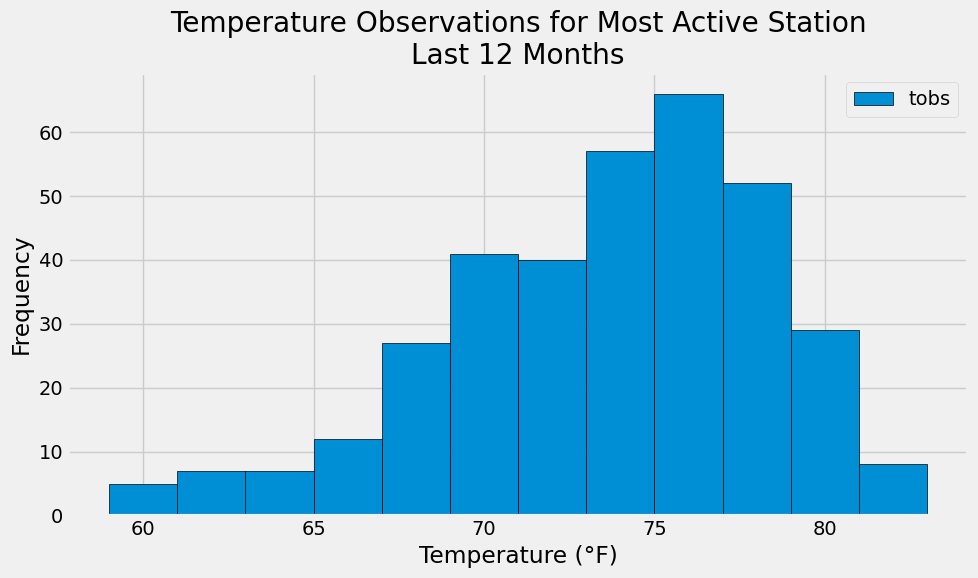

In [32]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=365)

results = session.query(Measurement.tobs).\
            filter(Measurement.station == most_active_station).\
            filter(Measurement.date >= one_year_ago).all()


temperatures = [result[0] for result in results]


# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for Most Active Station\nLast 12 Months')
plt.legend(['tobs'])
plt.tight_layout()
plt.show()

# Close Session

In [33]:
# Close Session
session.close()